In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rfpimp
!pip install pandas scikit-learn


In [ ]:
#Handling data as arrays
import numpy as np

#Handling data frames
import pandas as pd


#Plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#Stats functions
from scipy import stats
from scipy.interpolate import interpn

from sklearn.impute import SimpleImputer

In [ ]:
#Function to get denisty of points in scatterplot
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    return [x,y,z]

In [ ]:
#Read in data
Dat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NPF/In PNNL/aligned_data_2018_2023_all_0910.csv')
Dat

,date,time_hours,flag1,start_time,end_time,geometric_mean_nanosmps,smoothed_geometric_mean_nanosmps,geometric_mean_smps,total_N_conc_nanosmps,total_N_conc_smps,...,Particle_Size_47.8nm,Particle_Size_49.6nm,Particle_Size_51.4nm,Particle_Size_53.3nm,Particle_Size_55.2nm,Particle_Size_57.3nm,Particle_Size_59.4nm,Particle_Size_61.5nm,Particle_Size_63.8nm,Particle_Size_66.1nm
0,20220124,24.916667,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20230310,17.416667,0,NaN,NaN,11.679000,11.453555,86.569000,1.422325e+03,144915.9063,...,437.558990,0.000000,0.000000,0.000000,536.994995,263.274994,129.128998,253.434006,0.000000,NaN
2,20190519,18.416667,0,NaN,NaN,21.455999,15.142889,36.801998,2.662052e+06,342820.1875,...,428360.625000,602033.500000,352267.468800,604692.687500,730653.812500,318174.375000,376703.468800,298852.625000,NaN,NaN
3,20200207,15.250000,0,NaN,NaN,-1.000000,15.736333,51.287998,0.000000e+00,195883.2969,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,20220209,0.000000,0,NaN,NaN,16.075001,16.075001,NaN,9.354651e+03,NaN,...,3644.864990,2740.820068,2684.029053,2629.656982,3007.013916,3931.379883,3305.594971,2432.898926,2653.729004,973.427002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82063,20220204,23.583333,0,NaN,NaN,29.048000,29.799889,NaN,2.698778e+03,NaN,...,5460.711914,6170.363770,5947.880859,5956.639160,7685.229004,8685.955078,8826.195313,8661.707031,8564.194336,NaN
82064,20220204,23.666667,0,NaN,NaN,30.525999,28.971572,NaN,2.438412e+03,NaN,...,6062.346191,6226.537109,4645.937012,8392.806641,6029.304199,8481.500977,7293.150879,4916.337891,7365.696777,NaN
82065,20220204,23.750000,0,NaN,NaN,29.184000,28.842600,NaN,2.552164e+03,NaN,...,3937.959961,5485.640137,6243.454102,6464.700195,6212.925781,5879.587891,8450.527344,5923.543945,6719.930176,NaN
82066,20220204,23.833333,0,NaN,NaN,28.815001,28.213000,NaN,2.428662e+03,NaN,...,4241.333008,4860.155762,5878.076172,5796.428223,7530.454102,6563.789063,6170.672852,7108.847168,7039.741211,NaN


## Training the random forest model

In [ ]:
#Load in functions to split data and train random forest regression model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Regenerate Features from balanced_Dat
features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']
# features_columns = ['bl_height_1', 'total_organics', 'sulfate', 'nitrate', 'temperature_ambient', 'wind_direction', 'wind_speed']
Features = Dat[features_columns]

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
Features = imputer.fit_transform(Features)

# Define Independent variable
Independent = Dat[['flag3']]

# Check if the number of rows is now the same
print(Features.shape[0])
print(Independent.shape[0])

# Choose random seed for replication and split data into training and validation sets
np.random.seed(seed=42)
Features_df = pd.DataFrame(Features, columns=features_columns)
Features_df['random'] = np.random.random(size=len(Features_df))
X_train, X_valid, y_train, y_valid = train_test_split(Features_df, Independent, test_size=0.3, random_state=42)

X_train = X_train.drop('random', axis=1)
X_valid = X_valid.drop('random', axis=1)


82068
82068


In [ ]:
# Instantiate random forest model with 100 decision trees
rf = RandomForestClassifier (n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
# Train the model on training data
rf.fit(X_train,np.array(y_train).flatten());

# Use the forest's predict method on the test data
predictions = rf.predict(X_valid)

#Print accuracy scores
print('Training Score: {:.2f} \nOOB Score: {:.2f} \nValidation Score: {:.2f}'.format(rf.score(X_train, y_train),


Training Score: 1.00 
OOB Score: 0.97 
Validation Score: 0.97


10-fold

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp', 'wind_speed_interp',
                    'total_SA_conc_smps_interp', 'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Split the data into features and target variable
Features = Dat[features_columns]
Independent = Dat[['flag3']]

# To store the feature importances for each fold
feature_importances_per_fold = []

# Perform manual K-fold cross-validation
for train_index, test_index in kf.split(Features):
    # Use `.iloc` to correctly index the DataFrame by position
    X_train_fold, X_test_fold = Features.iloc[train_index], Features.iloc[test_index]
    y_train_fold, y_test_fold = Independent.iloc[train_index].values.ravel(), Independent.iloc[test_index].values.ravel()

    # Train the model on the current fold
    model.fit(X_train_fold, y_train_fold)

    # Capture feature importances for the current fold
    feature_importances_per_fold.append(model.feature_importances_)

# Convert to a NumPy array
feature_importances_per_fold = np.array(feature_importances_per_fold)

# Calculate mean and standard deviation of feature importances across folds
mean_importances = np.mean(feature_importances_per_fold, axis=0)
std_importances = np.std(feature_importances_per_fold, axis=0)

# Create a DataFrame to store the mean importance and standard deviation
importances_df = pd.DataFrame({
    'Feature': features_columns,
    'Mean Importance': mean_importances,
    'Importance Std': std_importances
})

# Create a dictionary mapping original feature names to their friendly names
feature_to_friendly_name = {
    'BestEstimate_down_short_hemisp_interp': 'Solar Radiation Intensity (SRI)',
    'rh_ambient_interp': 'Relative Humidity (RH)',
    'temperature_ambient_interp': 'Ambient Temperature ($T$)',
    'turbulent_kinetic_energy_interp': 'Turbulent Kinetic Energy (TKE)',
    'total_SA_conc_smps_interp': 'Total Surface Area Concentration ($S_{\\mathrm{tot}}$)',
    'wind_direction_interp': 'Wind Direction (Wdir)'
}

# Sort the importances_df by 'Mean Importance' to get the top six features
top_features_df = importances_df.sort_values(by='Mean Importance', ascending=False).head(6)

# Replace feature names with friendly names where available, otherwise keep original name
top_features_df['Feature'] = top_features_df['Feature'].map(feature_to_friendly_name).fillna(top_features_df['Feature'])

# Replace 'bl_height_1_interp' with 'wind_direction_interp' in top_features_df
# Find the row where 'bl_height_1_interp' exists and replace with 'wind_direction_interp'
if 'bl_height_1_interp' in top_features_df['Feature'].values:
    # Get the index where bl_height_1_interp is present
    index_to_replace = top_features_df[top_features_df['Feature'] == 'bl_height_1_interp'].index
    # Find the row in importances_df with wind_direction_interp
    wind_direction_row = importances_df[importances_df['Feature'] == 'wind_direction_interp']
    # Update top_features_df at the found index with wind_direction information
    top_features_df.loc[index_to_replace, 'Feature'] = 'Wind Direction (Wdir)'
    top_features_df.loc[index_to_replace, 'Mean Importance'] = wind_direction_row['Mean Importance'].values[0]
    top_features_df.loc[index_to_replace, 'Importance Std'] = wind_direction_row['Importance Std'].values[0]

# Verify the DataFrame is correct
print(top_features_df)




                                              Feature  Mean Importance  \
11                    Solar Radiation Intensity (SRI)         0.277849   
4                              Relative Humidity (RH)         0.172978   
5                           Ambient Temperature ($T$)         0.096103   
10                     Turbulent Kinetic Energy (TKE)         0.082125   
8   Total Surface Area Concentration ($S_{\mathrm{...         0.074639   
0                               Wind Direction (Wdir)         0.050332   

    Importance Std  
11        0.002871  
4         0.002154  
5         0.001133  
10        0.001249  
8         0.001023  
0         0.000195  


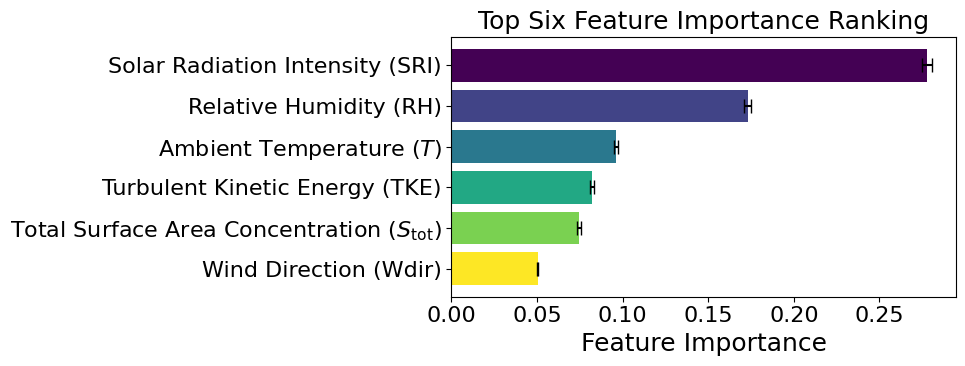

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate colors using the 'viridis' colormap, evenly spaced for each feature
colors = plt.cm.viridis(np.linspace(0, 1, num=len(top_features_df)))

# Plot using Matplotlib
plt.figure(figsize=(10, 4))

# Plot the bars with the specified colors
bars = plt.barh(top_features_df['Feature'], top_features_df['Mean Importance'],
                xerr=top_features_df['Importance Std'].values, capsize=5, color=colors)

# Customize the plot
plt.title('Top Six Feature Importance Ranking', fontsize=18)
plt.xlabel('Feature Importance', fontsize=18)

# Set the font size for the x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(Features, Independent, test_size=0.3, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train.values.ravel())

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate precision, recall, and F1-score for each class (0 and 1)
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix to derive class-specific accuracy
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate class-specific accuracy for class 0 and class 1 using the overall accuracy formula
# Accuracy for class 0: TP and TN are considered for class 0 as the positive class
accuracy_class_0 = (tn + tp) / (tp + fn + fp + tn)

# Accuracy for class 1: TP and TN are considered for class 1 as the positive class
accuracy_class_1 = (tp + tn) / (tp + fn + fp + tn)

# Print the results
print(f'Class 0 - Precision: {precision_class_0:.4f}, Recall: {recall_class_0:.4f}, F1-score: {f1_class_0:.4f}, Accuracy: {accuracy_class_0:.4f}')
print(f'Class 1 - Precision: {precision_class_1:.4f}, Recall: {recall_class_1:.4f}, F1-score: {f1_class_1:.4f}, Accuracy: {accuracy_class_1:.4f}')
print(f'Overall Accuracy: {accuracy:.4f}')


Class 0 - Precision: 0.9789, Recall: 0.9864, F1-score: 0.9826, Accuracy: 0.9726
Class 1 - Precision: 0.9491, Recall: 0.9227, F1-score: 0.9358, Accuracy: 0.9726
Overall Accuracy: 0.9726


In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp', 'wind_speed_interp',
                    'total_SA_conc_smps_interp', 'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Split the data into features and target variable
Features = Dat[features_columns]
Independent = Dat['flag3']

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up KFold cross-validation with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# To store accuracy for each fold
accuracy_per_fold = []

# Perform manual 10-fold cross-validation
for train_index, test_index in kf.split(Features):
    # Split the data into training and test sets for the current fold
    X_train_fold, X_test_fold = Features.iloc[train_index], Features.iloc[test_index]
    y_train_fold, y_test_fold = Independent.iloc[train_index], Independent.iloc[test_index]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = model.predict(X_test_fold)

    # Calculate accuracy for the current fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_per_fold.append(accuracy)

# Convert accuracy list to a NumPy array for easier calculations
accuracy_per_fold = np.array(accuracy_per_fold)

# Calculate mean and standard deviation of accuracy across all folds
mean_accuracy = np.mean(accuracy_per_fold)
std_accuracy = np.std(accuracy_per_fold)

# Print the results
print(f'Overall 10-Fold Cross-Validation Accuracy: Mean = {mean_accuracy:.4f}, Std = {std_accuracy:.4f}')


Overall 10-Fold Cross-Validation Accuracy: Mean = 0.9787, Std = 0.0017


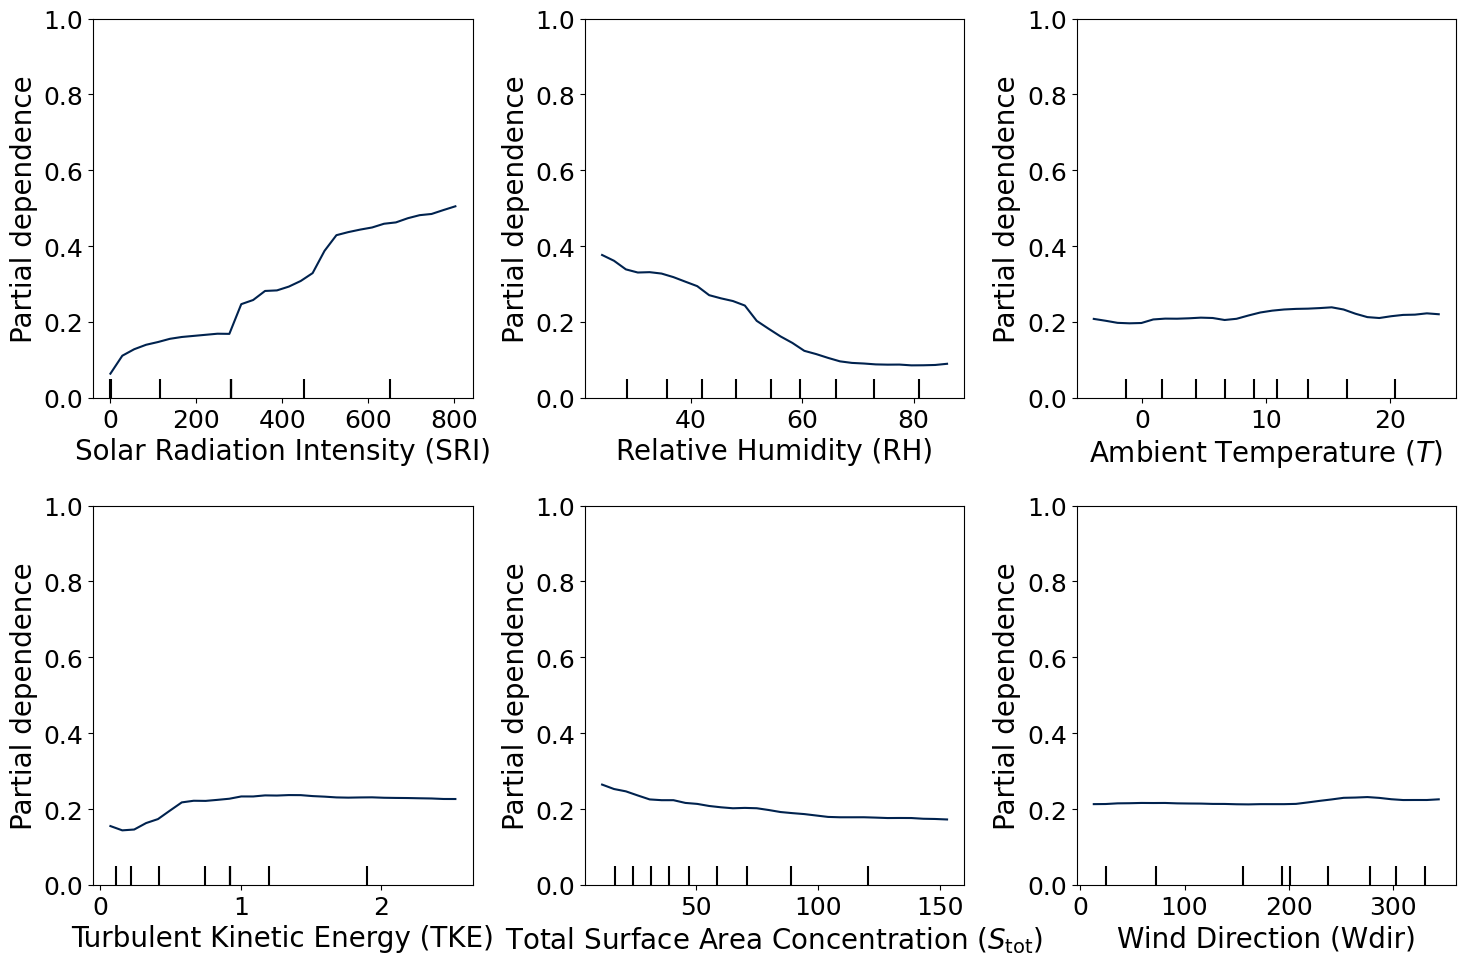

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.inspection import partial_dependence

# Set global parameters for consistent font sizes
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'axes.prop_cycle': plt.cycler('color', plt.cm.cividis(np.linspace(0, 1, 10)))
})

Dat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NPF/In PNNL/aligned_data_2018_2023_all_0910.csv')

features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels
friendly_names = [
    'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]

X = Dat[features_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Set up KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Select the features for which PDPs will be generated
sorted_features = ['Solar Radiation Intensity (SRI)', 'Relative Humidity (RH)', 'Ambient Temperature ($T$)',
                   'Turbulent Kinetic Energy (TKE)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)',
                   'Wind Direction (Wdir)']

# Dictionary to store partial dependence results
pdp_results = {feature: [] for feature in sorted_features}

# Perform K-Fold cross-validation
for train_index, _ in kf.split(X_imputed_df):
    X_train_fold = X_imputed_df.iloc[train_index]
    y_train_fold = y.iloc[train_index]

    # Train RandomForest model on the current fold
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
    rf.fit(X_train_fold, y_train_fold)

    # Calculate partial dependence for each feature
    for feature in sorted_features:
        feature_index = friendly_names.index(feature)
        pdp_result = partial_dependence(rf, X_train_fold, [feature_index], grid_resolution=30)

        # Extract the partial dependence values for the current feature
        pdp_values = pdp_result.average[0]  # Extract the PDP values correctly
        pdp_results[feature].append(pdp_values)

# Calculate mean and standard deviation for each feature's partial dependence
mean_pdp = {}
std_pdp = {}
for feature, pdp_values in pdp_results.items():
    pdp_values = np.array(pdp_values, dtype=float)  # Ensure correct data type
    mean_pdp[feature] = np.mean(pdp_values, axis=0)
    std_pdp[feature] = np.std(pdp_values, axis=0)

# Generate PDP plots with error bars
n_cols = 3  # Number of columns
n_rows = 2  # Number of rows to fit all top six features
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust the figure size as needed

for i, feature in enumerate(sorted_features):
    ax = axs.flat[i]
    feature_index = friendly_names.index(feature)

    # Generate Partial Dependence Plot using PartialDependenceDisplay
    PartialDependenceDisplay.from_estimator(
        rf, X_train_fold, features=[feature_index], feature_names=friendly_names, ax=ax, grid_resolution=30
    )
    ax.set_xlabel(feature)
    ax.set_ylabel('Partial Dependence')
    ax.tick_params(axis='both', top=False)  # Disable top ticks

for ax in fig.axes:
    ax.set_ylim(0, 1)  # Adjust y-axis limits as needed

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Examining variable importance

Models can be interpreted in several ways. One way is to examine variable importance.

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled

Similar importance scores can also be used for exploratory analysis and for understanding relative importance of different factors for describing a phenomenon, particularly relevant when the features are more or less independent.

### References

Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.

Venter, Z. S., Chakraborty, T., & Lee, X. (2021). Crowdsourced air temperatures contrast satellite measures of the urban heat island and its mechanisms. Science Advances, 7(22), eabb9569.

In [ ]:
#For computing permutation scores
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
def r2(model, X_train, y_train):
    return r2_score(y_train, model.predict(X_train))

In [ ]:
#Calculate permutation importance
perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
perm_imp_rfpimp

# Normalizing the permutation importances
perm_imp_rfpimp['Importance'] = perm_imp_rfpimp['Importance'] / perm_imp_rfpimp['Importance'].sum()

# Print normalized permutation importances
print(perm_imp_rfpimp)


                                       Importance
Feature                                          
BestEstimate_down_short_hemisp_interp    0.328713
rh_ambient_interp                        0.254257
temperature_ambient_interp               0.124356
turbulent_kinetic_energy_interp          0.104950
total_SA_conc_smps_interp                0.072871
wind_speed_interp                        0.038020
wind_direction_interp                    0.022970
bl_height_1_interp                       0.020594
nitrate_interp                           0.015446
total_organics_interp                    0.009505
sulfate_interp                           0.006337
so2_interp                               0.001980


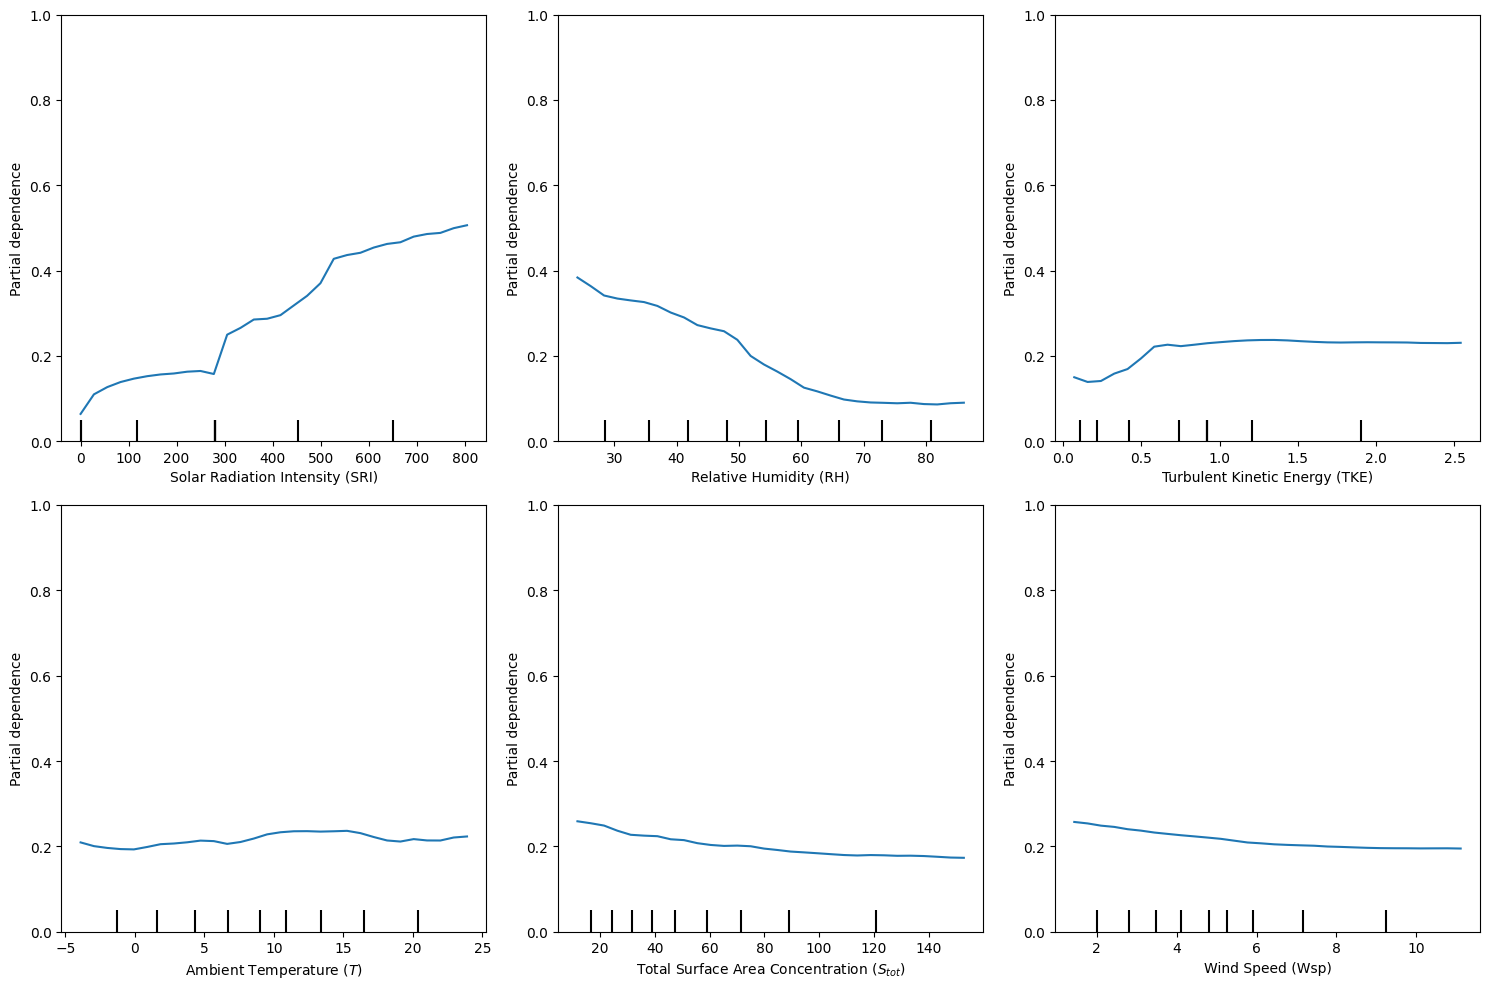

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels

friendly_names = [
        'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{tot}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]

X = Dat[features_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Calculate permutation importance
perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
sorted_features = perm_imp_rfpimp.index.tolist()[:6]  # Focus on the top six features

# Generate Partial Dependence Plots for the top six features
n_cols = 3  # Adjust the number of columns as needed
n_rows = 2  # Number of rows to fit all top six features
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust the figure size as needed

for i, feature in enumerate(sorted_features):
    ax = axs.flat[i]
    feature_index = friendly_names.index(feature)
    PartialDependenceDisplay.from_estimator(rf, X_train, features=[feature_index], feature_names=friendly_names, ax=ax, grid_resolution=30)
    ax.set_xlabel(ax.get_xlabel(), fontsize=25)  # Set x-axis label size
    ax.set_ylabel(ax.get_ylabel(), fontsize=25)  # Set y-axis label size
    ax.tick_params(axis='both', labelsize=20)  # Set tick label size
    ax.tick_params(top=False)  # Disable top ticks

# Set consistent y-axis limits after all plots have been generated
for ax in fig.axes:
    ax.set_ylim(0, 1)  # Adjust y-axis limits as needed

plt.tight_layout()
plt.show()


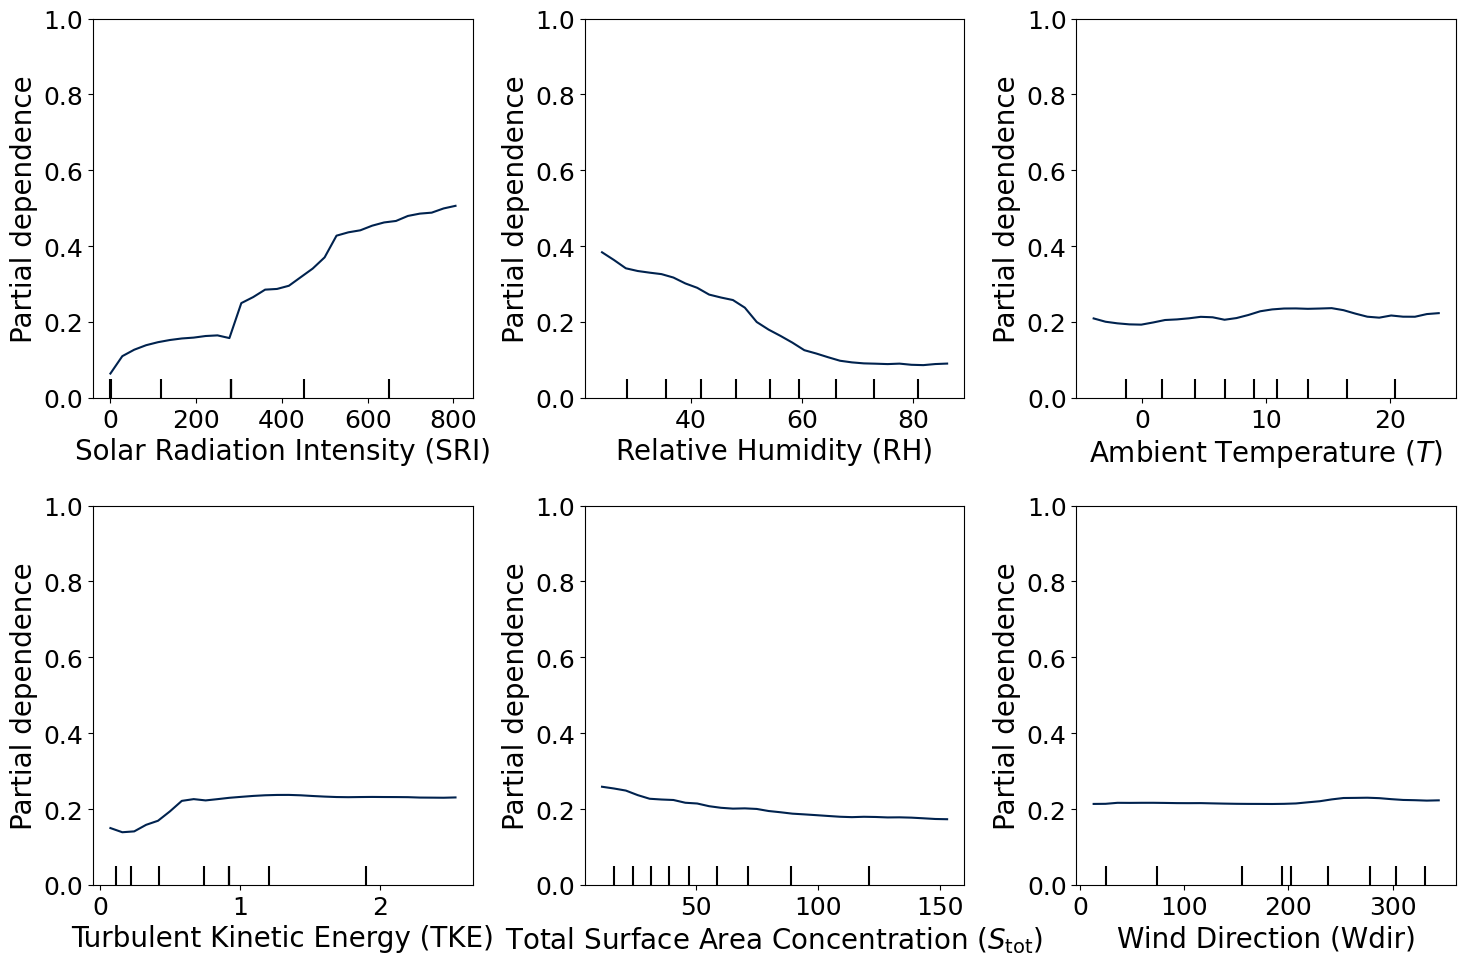

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

# Set global parameters to ensure font sizes are consistent
plt.rcParams.update({
    'font.size': 18,  # Sets the default font size
    'axes.labelsize': 20,  # Sets the fontsize for x and y labels
    'axes.titlesize': 20,  # Sets the fontsize for subplot titles if any
    'xtick.labelsize': 18,  # Sets the fontsize for the xticks
    'ytick.labelsize': 18,  # Sets the fontsize for the yticks
    'axes.prop_cycle': plt.cycler('color', plt.cm.cividis(np.linspace(0, 1, 10)))  # Uses the 'cividis' colormap
})

def r2(model, X, y):
    return r2_score(y, model.predict(X))

features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels

friendly_names = [
        'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]

X = Dat[features_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Calculate permutation importance
perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
sorted_features = ['Solar Radiation Intensity (SRI)', 'Relative Humidity (RH)', 'Ambient Temperature ($T$)',
                   'Turbulent Kinetic Energy (TKE)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)',
                   'Wind Direction (Wdir)']

# Generate Partial Dependence Plots for the top six features
n_cols = 3  # Adjust the number of columns as needed
n_rows = 2  # Number of rows to fit all top six features
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust the figure size as needed

for i, feature in enumerate(sorted_features):
    ax = axs.flat[i]
    feature_index = friendly_names.index(feature)
    PartialDependenceDisplay.from_estimator(rf, X_train, features=[feature_index], feature_names=friendly_names, ax=ax, grid_resolution=30)
    ax.set_xlabel(ax.get_xlabel())  # Now font sizes are globally set
    ax.set_ylabel(ax.get_ylabel())  # Now font sizes are globally set
    ax.tick_params(axis='both', top=False)  # Disable top ticks and keep other params

    # Set consistent y-axis limits after all plots have been generated
for ax in fig.axes:
    ax.set_ylim(0, 1)  # Adjust y-axis limits as needed

plt.tight_layout()
plt.show()



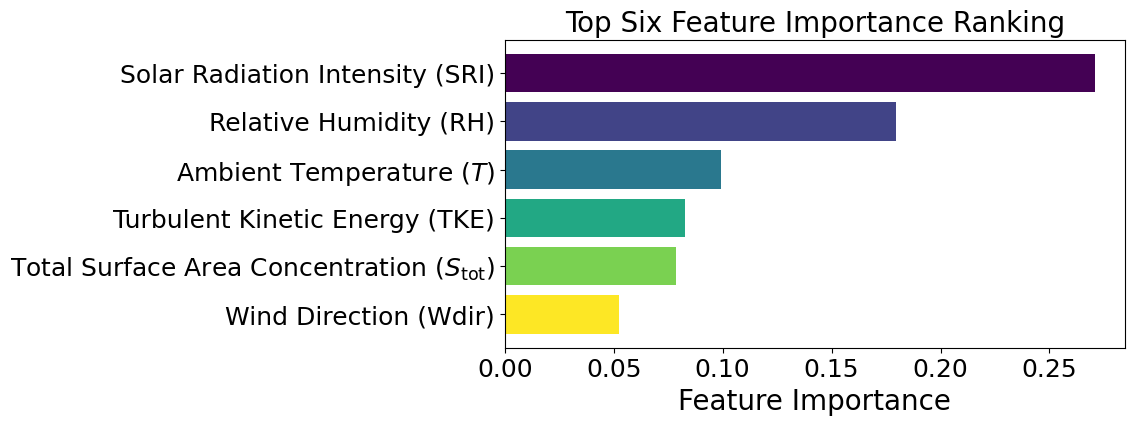

                                             Features  Importance
11                    Solar Radiation Intensity (SRI)    0.270965
4                              Relative Humidity (RH)    0.179549
5                           Ambient Temperature ($T$)    0.099312
10                     Turbulent Kinetic Energy (TKE)    0.082856
8   Total Surface Area Concentration ($S_{\mathrm{...    0.078712
6                               Wind Direction (Wdir)    0.052599


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Calculate feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for easier plotting
importances_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and select the top six
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(6)

# Plotting the Top 6 Feature Importances
plt.figure(figsize=(8, 4))  # Adjust size as needed
colors = plt.cm.viridis(np.linspace(0, 1, num=len(importances_df)))
plt.barh(importances_df['Features'], importances_df['Importance'], color=colors)
plt.xlabel('Feature Importance')
plt.title('Top Six Feature Importance Ranking')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
plt.show()

print(importances_df)

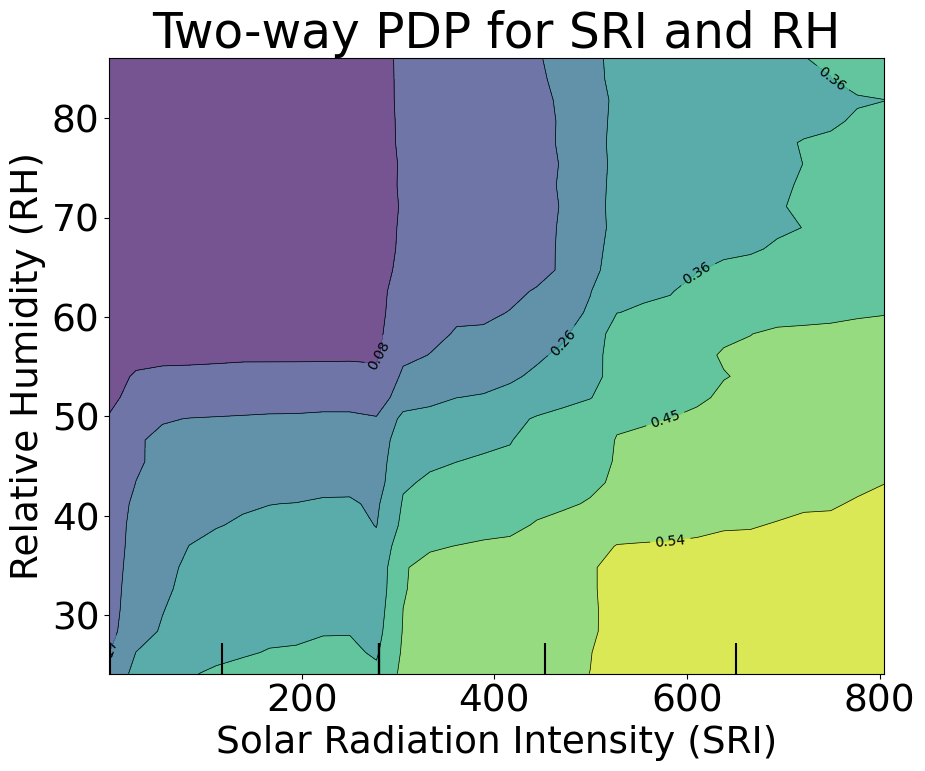

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

feature_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels
friendly_names = [
    'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]

X = Dat[feature_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Generate a two-way Partial Dependence Plot for the top two features
fig, ax = plt.subplots(figsize=(10, 8))
features_to_plot = (friendly_names.index('Solar Radiation Intensity (SRI)'), friendly_names.index('Relative Humidity (RH)'))
PartialDependenceDisplay.from_estimator(rf, X_train, features=[features_to_plot], feature_names=friendly_names, ax=ax, grid_resolution=30)
ax.tick_params(axis='both', labelsize=27)  # Ensure tick label size
ax.set_xlabel('SRI (W m$^{-2}$)', fontsize=32)  # Increase font size of the x-axis label
ax.set_ylabel('RH (%)', fontsize=32)  # Increase font size of the y-axis label
ax.set_title('Two-way PDP for SRI and RH', fontsize=35)
plt.show()


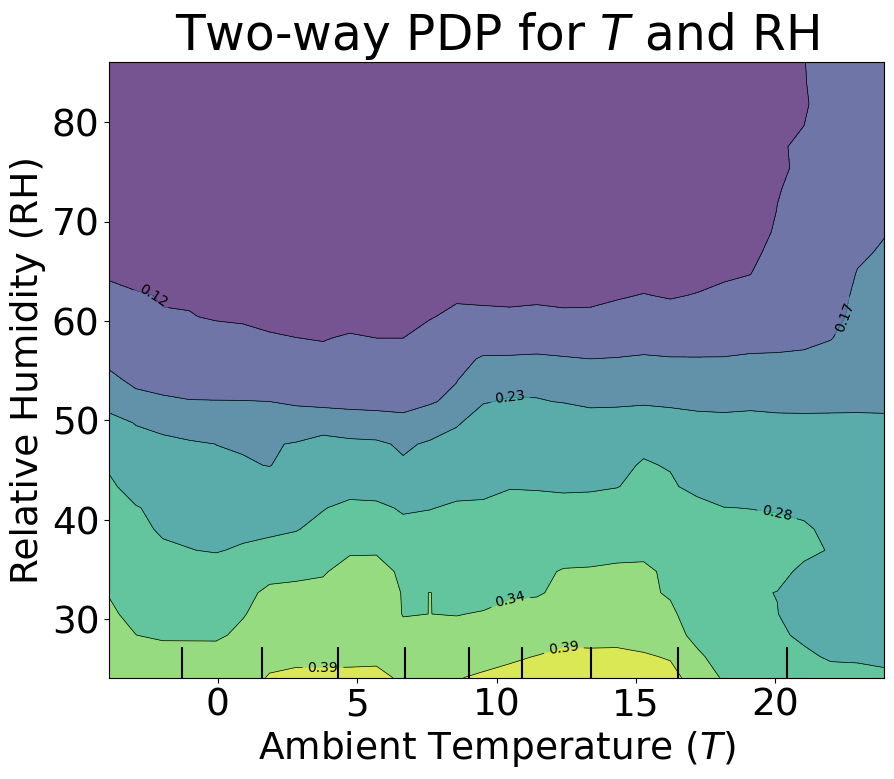

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

feature_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels
friendly_names = [
    'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]

X = Dat[feature_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Generate a two-way Partial Dependence Plot for Ambient Temperature and Relative Humidity
fig, ax = plt.subplots(figsize=(10, 8))
features_to_plot = [friendly_names.index('Ambient Temperature ($T$)'), friendly_names.index('Relative Humidity (RH)')]
PartialDependenceDisplay.from_estimator(rf, X_train, features=[features_to_plot], feature_names=friendly_names, ax=ax, grid_resolution=30)
ax.tick_params(axis='both', labelsize=27)  # Ensure tick label size
ax.set_xlabel('$T$ (°C)', fontsize=32)  # Increase font size of the x-axis label
ax.set_ylabel('RH (%)', fontsize=32)  # Increase font size of the y-axis label
ax.set_title('Two-way PDP for $T$ and RH', fontsize=35)
plt.show()


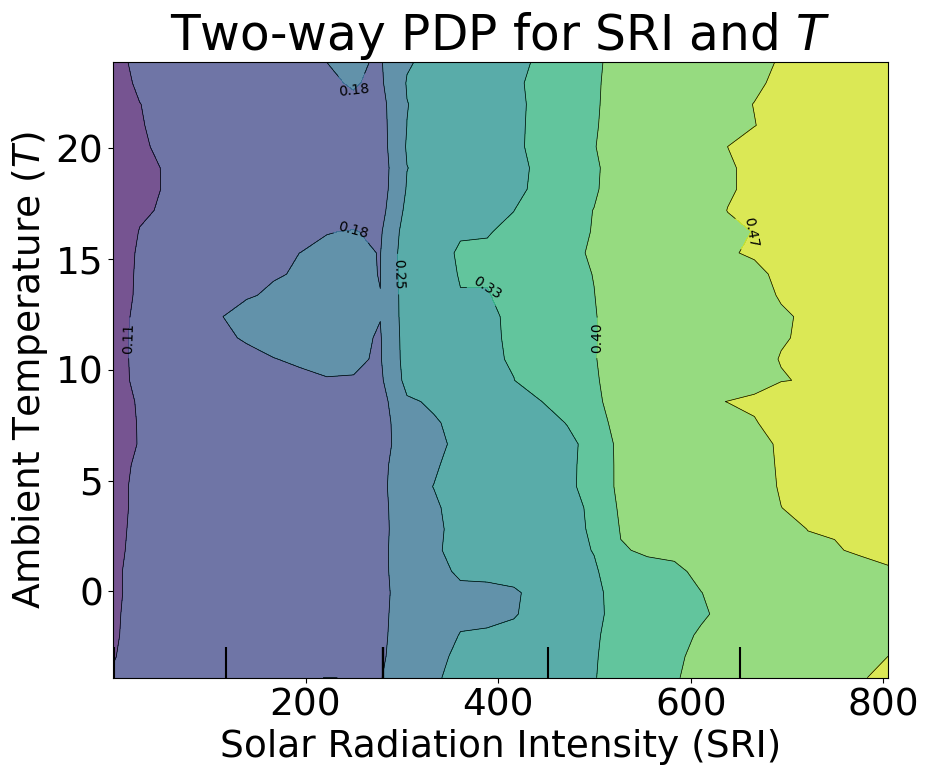

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

feature_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels
friendly_names = [
    'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]

X = Dat[feature_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Set global parameters for font size using rcParams
plt.rcParams.update({'font.size': 27})  # Adjust font size globally

# Generate a two-way Partial Dependence Plot for Ambient Temperature and Solar Radiation Intensity
fig, ax = plt.subplots(figsize=(10, 8))
features_to_plot = [friendly_names.index('Solar Radiation Intensity (SRI)'), friendly_names.index('Ambient Temperature ($T$)')]
PartialDependenceDisplay.from_estimator(rf, X_train, features=[features_to_plot], feature_names=friendly_names, ax=ax, grid_resolution=30)

# Set individual element sizes
ax.xaxis.set_major_locator(plt.MultipleLocator(100))  # Set major ticks interval
ax.tick_params(axis='both', labelsize=27)  # Ensure tick label size
ax.set_xlabel('SRI (W m$^{-2}$)', fontsize=32)  # Increase font size of the x-axis label
ax.set_ylabel('$T$ (°C)', fontsize=32)  # Increase font size of the y-axis label
ax.set_title('Two-way PDP for SRI and $T$', fontsize=35)
plt.show()


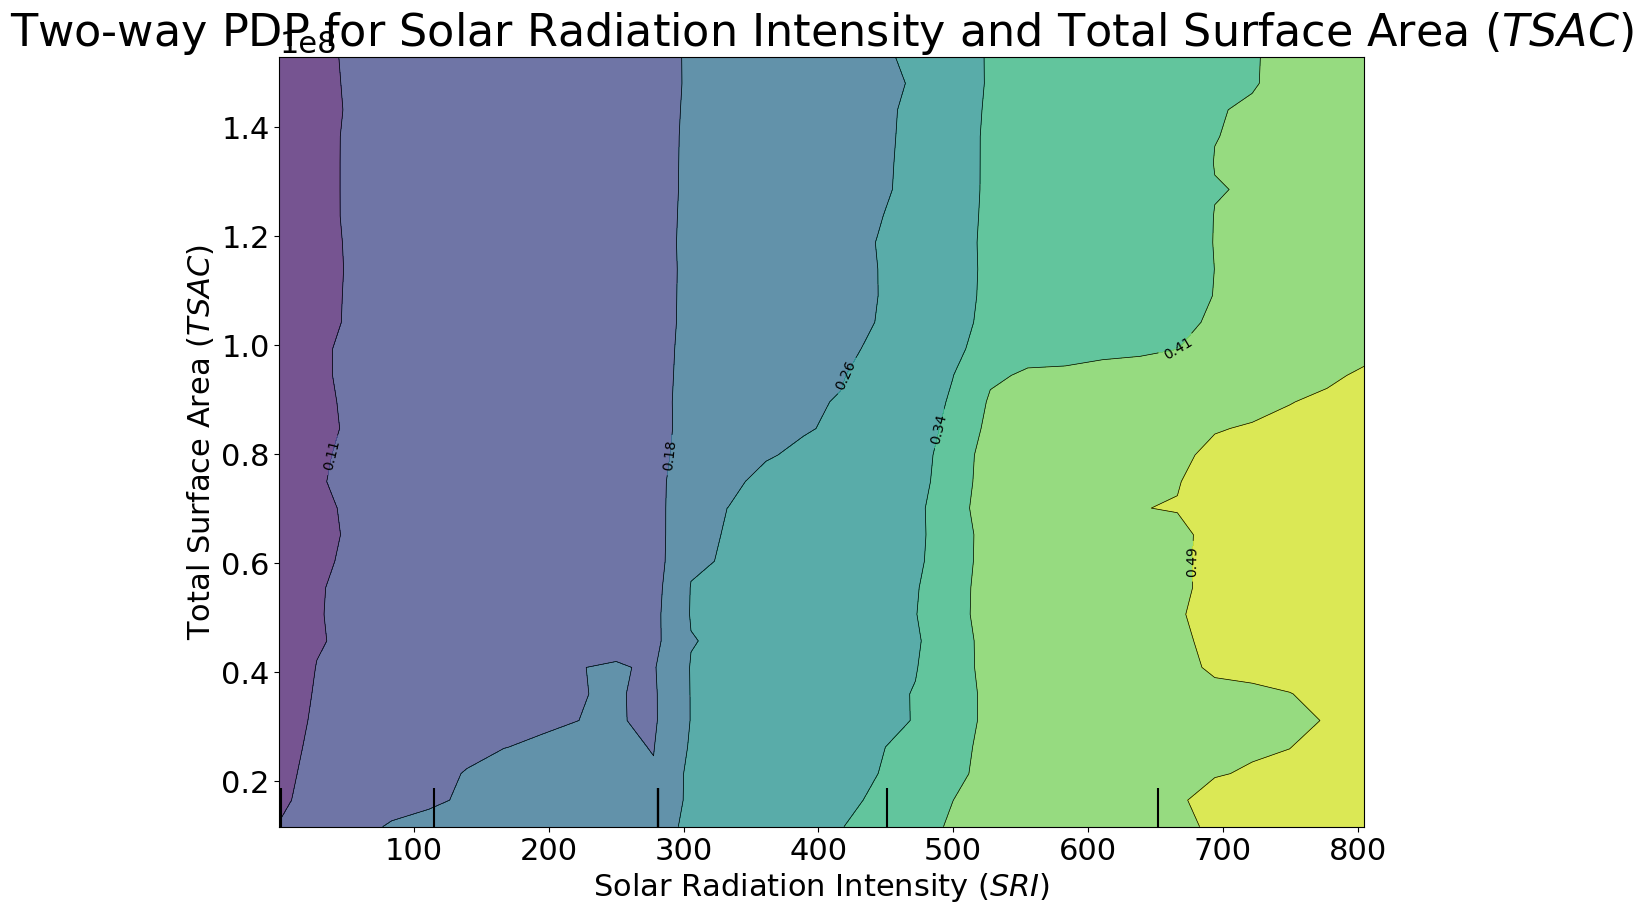

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

feature_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels
friendly_names = [
    'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]

X = Dat[feature_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Set global parameters for font size using rcParams
plt.rcParams.update({'font.size': 22})  # Adjust font size globally

# Generate a two-way Partial Dependence Plot for Ambient Temperature and Solar Radiation Intensity
fig, ax = plt.subplots(figsize=(14, 10))
features_to_plot = [friendly_names.index('Solar Radiation Intensity ($SRI$)'), friendly_names.index('Total Surface Area ($TSAC$)')]
PartialDependenceDisplay.from_estimator(rf, X_train, features=[features_to_plot], feature_names=friendly_names, ax=ax, grid_resolution=30)

# Set individual element sizes
ax.xaxis.set_major_locator(plt.MultipleLocator(100))  # Set major ticks interval
ax.tick_params(axis='both', labelsize=22)  # Ensure tick label size
ax.set_xlabel('Solar Radiation Intensity (SRI)', fontsize=30)  # Increase font size of the x-axis label
ax.set_ylabel('Total Surface Area ($TSAC$)', fontsize=30)  # Increase font size of the y-axis label
ax.set_title('Two-way PDP for Solar Radiation Intensity and Total Surface Area ($TSAC$)', fontsize=32)
plt.show()


In [ ]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X_train, y_train):
    return r2_score(y_train, model.predict(X_train))

# Calculate permutation importance
perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

# Normalize the importance scores
perm_imp_rfpimp['Importance'] = perm_imp_rfpimp['Importance'] / perm_imp_rfpimp['Importance'].sum()

print(perm_imp_rfpimp)


                                       Importance
Feature                                          
BestEstimate_down_short_hemisp_interp    0.326158
rh_ambient_interp                        0.242486
temperature_ambient_interp               0.120634
turbulent_kinetic_energy_interp          0.108042
total_SA_conc_smps_interp                0.085297
wind_speed_interp                        0.031682
wind_direction_interp                    0.022746
bl_height_1_interp                       0.020715
nitrate_interp                           0.019496
total_organics_interp                    0.011779
sulfate_interp                           0.009748
so2_interp                               0.001219


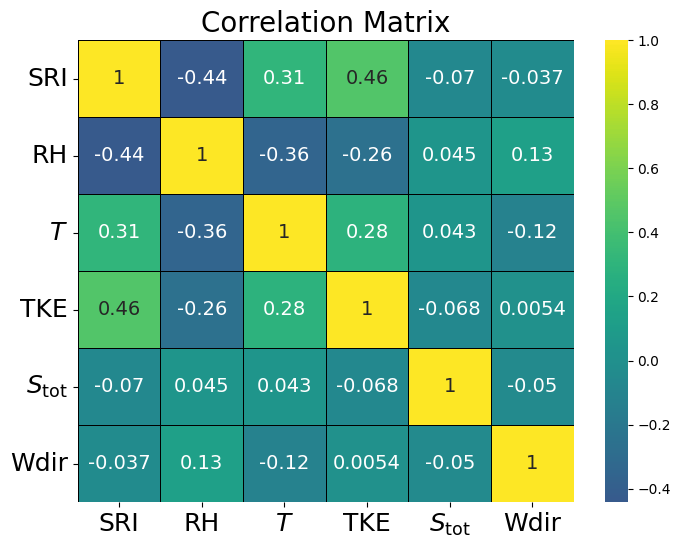

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/NPF/In PNNL/aligned_data_2018_2023_all_0910.csv'
data = pd.read_csv(file_path)

# Extract the relevant columns
relevant_data = data[['BestEstimate_down_short_hemisp_interp','rh_ambient_interp', 'temperature_ambient_interp', 'turbulent_kinetic_energy_interp', 'total_SA_conc_smps_interp','wind_direction_interp']]

# Rename columns for better readability
relevant_data.columns = ['SRI', 'RH', '$T$', 'TKE', '$S_{\mathrm{tot}}$', 'Wdir']

# Calculate the correlation matrix
correlation_matrix = relevant_data.corr()

# Plot the correlation matrix with colorblind-friendly color palette
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='viridis',   # Use 'cividis' for colorblind-friendly colors
            center=0,
            linewidths=0.5,
            linecolor='black',
            annot_kws={"size": 14})  # Increase annotation font size

# Set title and rotate labels for better readability
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(rotation=0, fontsize=18)  # Keep x-axis labels horizontal with larger font
plt.yticks(rotation=0, fontsize=18)  # Keep y-axis labels horizontal with larger font

plt.show()
